<a href="https://colab.research.google.com/github/SaiPavanKumarB/Music-Review-Ratings-Prediction/blob/main/Sri_Music_Ratings_Prediction_By_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Ratings Prediction based on reviews*


---



## Import libraries

In [51]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Read file

The ratings are provided as JSON file, which is loaded to GitHub for easy access.
File contains below details/columns


*   reviewerID
*   asin
*   reviewerName
*   helpful
*   reviewText - This is the main review that should be used for classification
*   overall - Ratings (Target column)
*   summary - Quick jist of the detailed review
*   Unixtime, reviewTime - Time columns


In [3]:
url = 'https://raw.githubusercontent.com/SaiPavanKumarB/Music-Review-Ratings-Prediction/main/Musical_Instruments_5.json'
df = pd.read_json(url,orient='records',dtype='dict',lines=True)
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"


In [4]:
df.shape

(10261, 9)

In [6]:
# convert the target column data type to int
df['overall'] = df['overall'].astype(int)

## Is the data balanced?

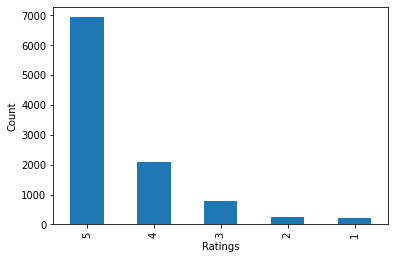

In [8]:
# Check the target column distribution
df['overall'].value_counts().plot(kind='bar')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

The dataset is highly imbalanced as there are more records for ratings 4,5 compared to the rest 3 ratings

Let's split the helpful column (list) to 2 seperate columns to see if it has something to say

In [21]:
df[['helpful_1','helpful_2']] = pd.DataFrame(df['helpful'].to_list())

## Base line model (using reviews alone)

Let's create a base line model following the below steps
*   Create dataframe using review & ratings alone
*   Tokenize the reviews
*   Create TF-IDF sparse matrix
*   Create Logistic Regression model









In [27]:
review_df = df[['reviewText','overall']]
review_df.rename({'reviewText':'Review','overall':'Rating'},axis=1,inplace=True)
review_df.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Review,Rating
0,"Not much to write about here, but it does exac...",5
1,The product does exactly as it should and is q...,5
2,The primary job of this device is to block the...,5


Split to train test with 80:20 ratio

In [31]:
review_df['Rating'] = review_df['Rating'].astype('category')
X = review_df.Review
y = review_df.Rating

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### TF-IDF Vectorizor
While using TF-IDF, we are considering the below
*   min_df is set to 5 i.e. consider word only when it's in atleast 5 reviews
*   Consider bigrams as well



In [53]:
# Fit the TfIDF on train data set & transform both train & test datasets
tfidf_vec = TfidfVectorizer(tokenizer=word_tokenize,lowercase=True,
                            sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')
tfidf_vec.fit(X_train)

xtrain = tfidf_vec.transform(X_train)
xtest = tfidf_vec.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


### Logistic Regression (with class_weights = 'balanced')

In [60]:
lg_model = LogisticRegression(class_weight='balanced',multi_class='auto',max_iter=1000) # Allow model to calculate class weights
lg_model.fit(xtrain,y_train)

preds = lg_model.predict(xtest)

print('Confusion Matrix')
print('*'*30)
cm = confusion_matrix(y_test,preds)
print(cm)

print('\n')
print('Classification Report')
print('*'*30)
print(classification_report(y_test,preds))

Confusion Matrix
******************************
[[  10   13    9    7    3]
 [   4    8   13   15   16]
 [   5    3   59   55   27]
 [   7   13   73  168  174]
 [   7   13   83  257 1011]]


Classification Report
******************************
              precision    recall  f1-score   support

           1       0.30      0.24      0.27        42
           2       0.16      0.14      0.15        56
           3       0.25      0.40      0.31       149
           4       0.33      0.39      0.36       435
           5       0.82      0.74      0.78      1371

    accuracy                           0.61      2053
   macro avg       0.37      0.38      0.37      2053
weighted avg       0.65      0.61      0.63      2053



Not so great performance. Still the model is predicting rating 5 which is why we have better precision/recall for 5 alone

### XgBoost

In [58]:
xgb_clf = xgb.XGBClassifier(n_estimators=200,learning_rate=0.05,max_depth=6,objective='multi:softprob',random_state=10)
xgb_clf.fit(xtrain,y_train)

preds = xgb_clf.predict(xtest)

print('Confusion Matrix')
print('*'*30)
cm = confusion_matrix(y_test,preds)
print(cm)

print('\n')
print('Classification Report')
print('*'*30)
print(classification_report(y_test,preds))

Confusion Matrix
******************************
[[   0    0    1    0   41]
 [   0    0    1    5   50]
 [   0    0    8   14  127]
 [   0    1    3   42  389]
 [   0    0    3   20 1348]]


Classification Report
******************************
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        42
           2       0.00      0.00      0.00        56
           3       0.50      0.05      0.10       149
           4       0.52      0.10      0.16       435
           5       0.69      0.98      0.81      1371

    accuracy                           0.68      2053
   macro avg       0.34      0.23      0.21      2053
weighted avg       0.61      0.68      0.58      2053



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Not great

### Naive Bayes

In [80]:
NB_clf = MultinomialNB()
NB_clf.fit(xtrain,y_train)

preds = NB_clf.predict(xtest)

print('Confusion Matrix')
print('*'*30)
cm = confusion_matrix(y_test,preds)
print(cm)

print('\n')
print('Classification Report')
print('*'*30)
print(classification_report(y_test,preds))

Confusion Matrix
******************************
[[   0    0    0    0   42]
 [   0    0    0    0   56]
 [   0    0    0    0  149]
 [   0    0    0    0  435]
 [   0    0    0    0 1371]]


Classification Report
******************************
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        42
           2       0.00      0.00      0.00        56
           3       0.00      0.00      0.00       149
           4       0.00      0.00      0.00       435
           5       0.67      1.00      0.80      1371

    accuracy                           0.67      2053
   macro avg       0.13      0.20      0.16      2053
weighted avg       0.45      0.67      0.53      2053



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XgBoost With Class Weights

In [66]:
from sklearn.utils import class_weight

class_weights = list(class_weight.compute_class_weight('balanced',
                                                       np.unique(y_train),
                                                       y_train))
class_weights

[9.380571428571429,
 8.461855670103093,
 2.634991974317817,
 0.9955124317768345,
 0.29488054607508535]

Create a weight vector

In [77]:
weights = np.ones(X_train.shape[0],dtype='float')

for i,val in enumerate(review_df.loc[y_train.index]['Rating']):
  weights[i] = class_weights[val-1] # -1 because ratings are from 1-5 whereas index will be from 0 to 4

print(weights)

[0.99551243 0.99551243 0.29488055 ... 0.29488055 0.29488055 0.99551243]


In [78]:
xgb_clf = xgb.XGBClassifier(n_estimators=300,learning_rate=0.05,max_depth=6,objective='multi:softprob',random_state=10)
xgb_clf.fit(xtrain,y_train,sample_weight=weights)

preds = xgb_clf.predict(xtest)

print('Confusion Matrix')
print('*'*30)
cm = confusion_matrix(y_test,preds)
print(cm)

print('\n')
print('Classification Report')
print('*'*30)
print(classification_report(y_test,preds))

Confusion Matrix
******************************
[[  6  11  10   5  10]
 [  5   5  13  16  17]
 [  2   7  44  55  41]
 [  2  13  66 174 180]
 [ 12  23  97 274 965]]


Classification Report
******************************
              precision    recall  f1-score   support

           1       0.22      0.14      0.17        42
           2       0.08      0.09      0.09        56
           3       0.19      0.30      0.23       149
           4       0.33      0.40      0.36       435
           5       0.80      0.70      0.75      1371

    accuracy                           0.58      2053
   macro avg       0.33      0.33      0.32      2053
weighted avg       0.62      0.58      0.60      2053



In [ ]:
from google.colab import drive
drive.mount('/content/drive')